# Time Series Analysis
**Short-term temperature forecoast**

- understand the purpose of Time Series Analysis
- understand the concept of **time dependence** in time series data
- understand how to use AR and ARIMA models in order to predict the future

Checklist
- read a temperature curve
- decompose the time series
- train a linear model
- try other forecasting methods
- calculate quality metrics
- download more data
- plot climate data on a map

## 1. Download and read the data

- Go to www.ecad.eu
- Go to “Daily data”
- Click on “Custom query (ASCII)”
- Pick:
    - Type of series: blend
    - Country: Germany
    - Location: Berlin-Tempelhof
    - Element: Mean temperature


- read the data into a dataframe

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:

df = pd.read_csv('data/ECA_blended_custom/TG_STAID002759_descr_removed.txt') # , header=0, sep=',', quotechar='"'
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [19]:
df.info() # whitespaces in column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    52808 non-null  int64
 1       DATE  52808 non-null  int64
 2      TG     52808 non-null  int64
 3    Q_TG     52808 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [20]:
df.loc[0]

 SOUID        127488
    DATE    18760101
   TG             22
 Q_TG              0
Name: 0, dtype: int64

In [21]:
# remove whitespaces in df
df = df.rename(columns=lambda x: x.strip())

In [22]:
df.loc[0]

SOUID      127488
DATE     18760101
TG             22
Q_TG            0
Name: 0, dtype: int64

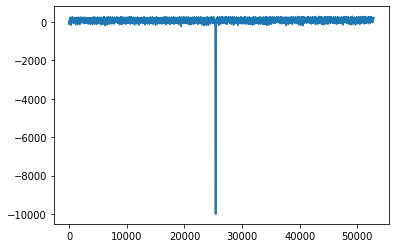

In [23]:
df['TG'].plot()

In [24]:
# format "DATE" column to datetime and set it as index 

df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'), inplace=True)
df.head()

,SOUID,DATE,TG,Q_TG
DATE,,,,
1876-01-01,127488,18760101,22,0
1876-01-02,127488,18760102,25,0
1876-01-03,127488,18760103,3,0
1876-01-04,127488,18760104,-58,0
1876-01-05,127488,18760105,-98,0


Recommendations for the missing data (-9999 degrees in Apr-Nov 1945):
cut out the entire year (and see how far you get)
insert the missing days with the average of that day from 1944 + 1946 (using a for loop)

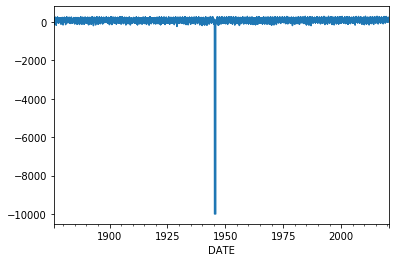

In [25]:
# plot the raw temperature data
#(note that the unit of the temperature is 0.1 °C)
df['TG'].plot()

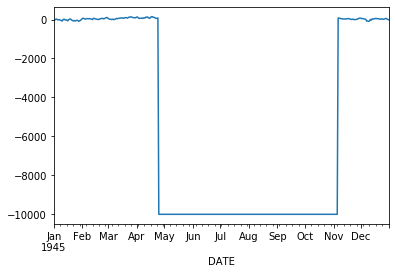

In [26]:
# zoom in the outlier area:
df.loc['1945-01-01':'1945-12-31', 'TG'].plot() # may to november 1945 the same value

In [27]:
df_year_1945 = df.loc['1945-01-01':'1945-12-31']



for row in df_year_1945.itertuples():
    temp = row[3]
    if temp == -9999:
        temp_44 = df.at[(row.Index - pd.DateOffset(years=1), 'TG')]
        temp_46 = df.at[(row.Index + pd.DateOffset(years=1), 'TG')]
        mean = (temp_44 + temp_46) / 2
        df.at[row.Index, 'TG'] = mean

print(df.loc['1945-04-01':'1945-04-30'])

             SOUID      DATE   TG  Q_TG
DATE                                   
1945-04-01  127488  19450401  130     0
1945-04-02  127488  19450402  122     0
1945-04-03  127488  19450403   68     0
1945-04-04  127488  19450404   59     0
1945-04-05  127488  19450405   68     0
1945-04-06  127488  19450406   67     0
1945-04-07  127488  19450407   72     0
1945-04-08  127488  19450408   60     0
1945-04-09  127488  19450409   94     0
1945-04-10  127488  19450410   75     0
1945-04-11  127488  19450411  128     0
1945-04-12  127488  19450412  114     0
1945-04-13  127488  19450413  128     0
1945-04-14  127488  19450414   78     0
1945-04-15  127488  19450415   58     0
1945-04-16  127488  19450416  101     0
1945-04-17  127488  19450417  148     0
1945-04-18  127488  19450418  148     0
1945-04-19  127488  19450419  114     0
1945-04-20  127488  19450420  110     0
1945-04-21  127488  19450421   81     0
1945-04-22  127488  19450422   57     0
1945-04-23  127488  19450423   61     0


### Decomposition:
y = trend + variance change + seasonality + X + noise 


### Differential: Trend

In [30]:
df['diff'] = df['TG'].diff() # differential
# just the difference between the previous and the current count

In [31]:
df['diff'].mean()

0.003427575889560096

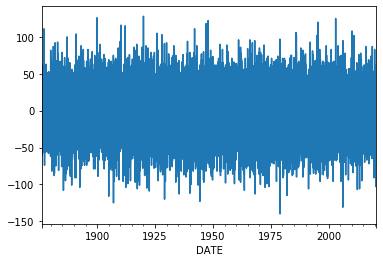

In [32]:
df['diff'].plot()

### Percentage change
removes trend and variance change

In [36]:
df['pct'] = df['TG'].pct_change()
df.head()

,SOUID,DATE,TG,Q_TG,diff,pct
DATE,,,,,,
1876-01-01,127488,18760101,22,0,NaN,NaN
1876-01-02,127488,18760102,25,0,3.0,0.136364
1876-01-03,127488,18760103,3,0,-22.0,-0.880000
1876-01-04,127488,18760104,-58,0,-61.0,-20.333333
1876-01-05,127488,18760105,-98,0,-40.0,0.689655


In [ ]:
# replace NaN with zeros?

In [38]:
df['pct'].mean()

nan

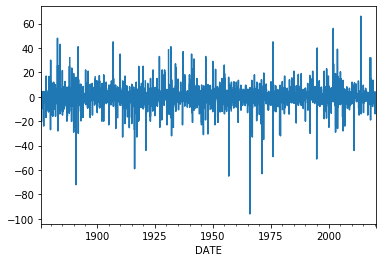

In [39]:
df['pct'].plot()

### Seasonality

In [44]:
# create month column from DATETIME index 
df['month'] = df.index.month
df.head()

,SOUID,DATE,TG,Q_TG,diff,pct,month
DATE,,,,,,,
1876-01-01,127488,18760101,22,0,NaN,NaN,1
1876-01-02,127488,18760102,25,0,3.0,0.136364,1
1876-01-03,127488,18760103,3,0,-22.0,-0.880000,1
1876-01-04,127488,18760104,-58,0,-61.0,-20.333333,1
1876-01-05,127488,18760105,-98,0,-40.0,0.689655,1


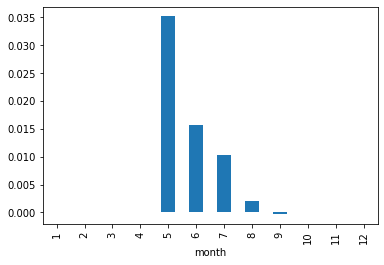

In [45]:
# monthly means
mm = df.groupby('month')['pct'].mean()
mm.plot.bar()

In [46]:
# we need a Series that is as long as our df
df.shape

(52808, 7)

In [47]:
mm.shape

(12,)

In [64]:
# cut off the last rows of the dataframe (after XX-12-31)
# to be able to create month_means column

# insert monthly mean value to the according month in the DF
# for i len(data frame col):
    for col[i] == i # get the value of the row
    access first (0) element in the list of mm
    insert this value in new column monthly means
    increase the value by 1 

#df_year_1945 = df.loc['1945-01-01':'1945-12-31']
df_cut_2019 = df.loc[:'2019-12-31']
df_cut_2019.head(20)

,SOUID,DATE,TG,Q_TG,diff,pct,month
DATE,,,,,,,
1876-01-01,127488,18760101,22,0,NaN,NaN,1
1876-01-02,127488,18760102,25,0,3.0,0.136364,1
1876-01-03,127488,18760103,3,0,-22.0,-0.880000,1
1876-01-04,127488,18760104,-58,0,-61.0,-20.333333,1
1876-01-05,127488,18760105,-98,0,-40.0,0.689655,1
1876-01-06,127488,18760106,-77,0,21.0,-0.214286,1
1876-01-07,127488,18760107,-66,0,11.0,-0.142857,1
1876-01-08,127488,18760108,-89,0,-23.0,0.348485,1
1876-01-09,127488,18760109,-127,0,-38.0,0.426966,1


In [62]:
df_cut_2019.shape

(52595, 7)

In [63]:
df['month_means'] = list(mm) * 12

ValueError: Length of values does not match length of index

In [49]:
df['detrend_div'] = df['pct'] / df['month_means']
df['detrend_div'].plot() # identifies outliers
df['detrend_div'].mean()
df['detrend_div'].hist(bins=20)#

KeyError: 'month_means'

In [50]:
df['detrend_sub'] = df['pct'] - df['month_means']
df['detrend_sub'].hist(bins=20) # subtraction is more robust

KeyError: 'month_means'

In [51]:

from statsmodels.tsa.seasonal import seasonal_decompose

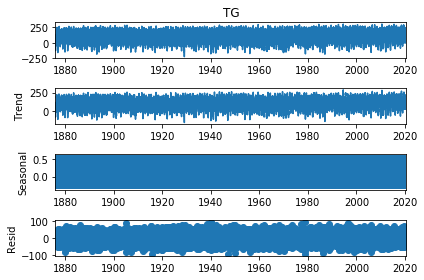

In [53]:
# additive == diff
x = seasonal_decompose(df['TG'])
plot = x.plot() 

In [55]:
# # multiplicative == diff
# x2 = seasonal_decompose(df['TG'], model='multiplicative')
# plot2 = x2.plot()
# # Multiplicative seasonality is not appropriate for zero and negative values

ValueError: Multiplicative seasonality is not appropriate for zero and negative values